In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.7 MB/s eta 0:00:00


In [ ]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

Define Agent

In [ ]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "The messages is in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [24]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature=0,
    groq_api_key = ""YOUR_GROQ_API_KEY_HERE"",
    model_name = "llama-3.3-70b-versatile"
)


In [ ]:
itenerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Create a day trip itenary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itenerary."),
    ("human", "Create an itenary for my day trip."),
])

Define agent Function

In [ ]:
def input_city(state : PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your Input:")
  return{
      **state,
      "city": user_message,
      "messages": state['messages']+ [HumanMessage(content=user_message)]
  }
def input_interests(state : PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip to: {state['city']}(comma-seperated): ")
  user_message = input("Your Input:")
  return{
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state['messages']+ [HumanMessage(content=user_message)]
  }
def create_itenerary(state : PlannerState) -> PlannerState:
  print(f"Creating an itenerary for {state['city']}based on interests:{','.join(state['interests'])} "),
  response = llm.invoke(itenerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
  print("\n Final Itenerary: ")
  print(response.content)
  return{
      **state,
      "messages": state['messages']+ [AIMessage(content= response.content)],
      "itenerary": response.content,
  }

create and compile the graph

In [ ]:
from ast import Starred
workflow = StateGraph(PlannerState)
workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itenerary", create_itenerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itenerary")
workflow.add_edge("create_itenerary", END)

app = workflow.compile()


display the graph structure

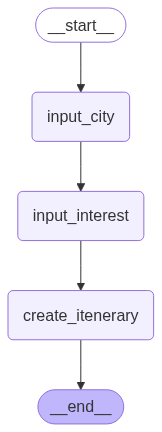

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

Dfine the function that runs the graph

In [ ]:
def travel_planner(user_request:str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages" : [HumanMessage(content=user_request)],
      "city" : "",
      "interests:": [],
      "itenerary": "",
  }
  for output in app.stream(state):
    pass

In [ ]:
user_request= " i want to plan a day trip"
travel_planner(user_request)

Initial Request:  i want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input:Uttarakhand
Please enter your interest for the trip to: Uttarakhand(comma-seperated): 
Your Input:kedarnath
Creating an itenerary for Uttarakhandbased on interests:kedarnath 

 Final Itenerary: 
Here's a brief, bulleted itinerary for a day trip to Kedarnath, Uttarakhand:

* 6:00 AM: Start the day with a drive to Gaurikund (approximately 32 km from Sonprayag)
* 8:00 AM: Begin the 14 km trek to Kedarnath Temple
* 12:00 PM: Reach Kedarnath Temple and explore the surroundings
* 1:00 PM: Have lunch at a local eatery
* 2:00 PM: Visit the Kedarnath Temple and take part in the puja or darshan
* 4:00 PM: Start the trek back to Gaurikund
* 7:00 PM: Return to Sonprayag and conclude the day trip

Note: The itinerary may vary depending on your physical fitness, weather conditions, and other factors. It's recommended to check the weather forecast and temple timings before embarking on 

In [ ]:
!pip install gradio


In [28]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages is in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="YOUR_GROQ_API_KEY_HERE",
    model_name="llama-3.3-70b-versatile"
)

# Define the itinerary prompt
itenerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Create a day trip itenary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itenerary."),
    ("human", "Create an itenary for my day trip."),
])

def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }

def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(
        itenerary_prompt.format_messages(
            city=state['city'],
            interests=','.join(state['interests'])
        )
    )
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Define the Gradio application
def travel_planner(city: str, interests: str):
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the city and interests inputs
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip planner",
)

interface.launch()



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d5b3c9e23b7ea8e848.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
